<a href="https://colab.research.google.com/github/Mohammadhsiavash/DeepL-Training/blob/main/Computer%20Vision/Image_Style_Transfer_(Neural_Style_Transfer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transfer the visual style of one image (style) onto the content of another image using
a pretrained neural style transfer model.

### Load and Preprocess Content and Style Images

You can upload files using the following code:

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Alternatively, you can use example images. I'll modify the code to use example image URLs.

In [1]:
from PIL import Image
import requests
from io import BytesIO
import torchvision.transforms as transforms

# Preprocessing
transform = transforms.Compose([
  transforms.Resize((1024, 1024)),
  transforms.ToTensor()
])

# Load images from URLs
def load_image_from_url(url):
    response = requests.get(url)
    response.raise_for_status() # Raise an exception for bad status codes
    # Use BytesIO to simulate a file
    img_data = BytesIO(response.content)
    img = Image.open(img_data).convert("RGB")
    return transform(img).unsqueeze(0) # Add batch dimension


# Using direct image URLs
content_url = "https://wallpapers.com/images/hd/van-gogh-wheat-field-with-cypresses-5uq91o74ejxb9aq4.jpg"
style_url = "http://wallup.net/wp-content/uploads/2016/01/102787-nature-mountain-river-landscape.jpg"


content_img = load_image_from_url(content_url)
style_img = load_image_from_url(style_url)

print("Images loaded successfully!")

Images loaded successfully!


### Load the Pretrained Style Transfer Model

In [2]:
import torch
import torchvision.models as models
# Load VGG19 and freeze parameters
vgg = models.vgg19(pretrained=True).features.eval()
for param in vgg.parameters():
  param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Define Feature Extraction and Loss Functions

In [3]:
import torch.nn as nn
# Feature layers to use for content and style
content_layers = ['21'] # relu4_2
style_layers = ['0', '5', '10', '19', '28'] # relu1_1 to relu5_1
# Create module to get intermediate layers
class VGGFeatures(nn.Module):
  def __init__(self):
    super(VGGFeatures, self).__init__()
    self.chosen_layers = content_layers + style_layers
    self.model = vgg
    # Create a dictionary to map layer indices to their names
    self.layer_names = {str(i): name for i, (name, layer) in enumerate(self.model.named_children())}

  def forward(self, x):
    features = {}
    # Iterate through layers by index and name
    for i, (name, layer) in enumerate(self.model.named_children()):
        x = layer(x)
        # Check if the layer index (as a string) is in the chosen layers
        if str(i) in self.chosen_layers:
            features[str(i)] = x
    return features

def gram_matrix(tensor):
  b, c, h, w = tensor.size()
  tensor = tensor.view(c, h * w)
  return torch.mm(tensor, tensor.t()) / (c * h * w)

### Optimize the Output Image

In [5]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
content_img = content_img.to(device)
style_img = style_img.to(device)
generated_img = content_img.clone().requires_grad_(True).to(device)
model = VGGFeatures().to(device)
optimizer = optim.Adam([generated_img], lr=0.01)
# Style weights
style_weight = 1e3 # Reduced style weight
content_weight = 1
for step in range(300):
  optimizer.zero_grad()
  gen_features = model(generated_img)
  content_features = model(content_img)
  style_features = model(style_img)
  content_loss = torch.mean((gen_features['21'] - content_features['21'])**2)
  style_loss = 0
  for layer in style_layers:
    G = gram_matrix(gen_features[layer])
    A = gram_matrix(style_features[layer])
    style_loss += torch.mean((G - A)**2)
  total_loss = content_weight * content_loss + style_weight * style_loss
  total_loss.backward()
  optimizer.step()
  if step % 50 == 0:
    print(f"Step {step}, Total Loss: {total_loss.item():.2f}")

Step 0, Total Loss: 2.89


### Display and Save the Result

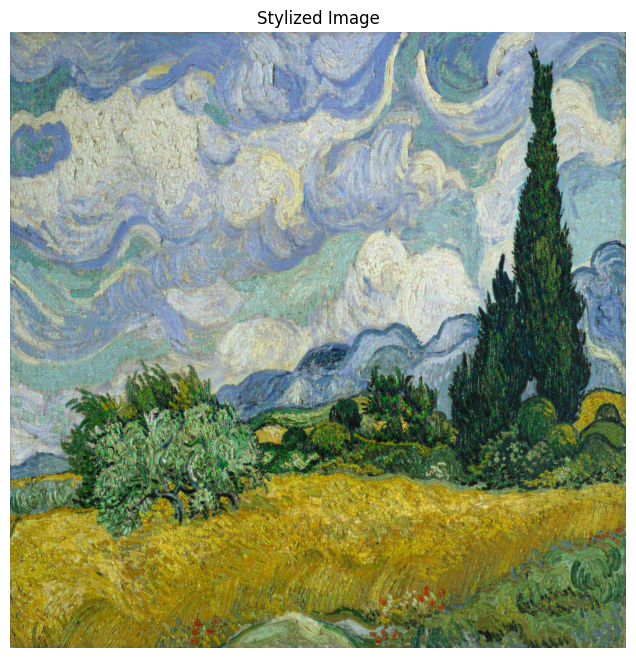

In [6]:
import matplotlib.pyplot as plt
def im_convert(tensor):
  image = tensor.cpu().clone().detach().squeeze(0)
  image = image.numpy().transpose(1, 2, 0)
  return image.clip(0, 1)
plt.figure(figsize=(8, 8))
plt.imshow(im_convert(generated_img))
plt.title("Stylized Image")
plt.axis('off')
plt.show()
# Save to file
output_image = transforms.ToPILImage()(generated_img.squeeze().cpu())
output_image.save("stylized_output.jpg")